In [1]:
import jax.numpy as jnp
import numpy as np

import scanpy as sc
import seaborn as sns

from gstatot import gStatOT, StatOT, metrics, utils, driver_genes

sns.set_context("paper", font_scale=1.5)
sns.set_theme(style="ticks")

In [ ]:
data_dir = '../extra/data/hemo_data/prefitted_adatas'

adata_keys  = {'time_key': 'smoothed_age',
               'cell_type_key': 'sink_type',
               'growth_rate_key': 'growth_rate',
               'embed_key': 'X_pca'}

n = 250 # number of cells per time point
key = 42 

# run '../extra/data_preprocessing/hematopoiesis/hemo_preprocessing.ipynb' to generate these files
# or download them from the archive "preprocessed_adatas.tar.gz" from https://doi.org/9.5281/zenodo.18121450 
# and extract to the appropriate directory

postnatal_adata = sc.read_h5ad(f'{data_dir}/postnatal_statOT_fitted.h5ad') # load preprocessed data
prenatal_adata = sc.read_h5ad(f'{data_dir}/prenatal_statOT_fitted.h5ad')

# gStatOT

Cost scaled by mean
Completed 5000 total iterations, current error: 8.3741e-03
Completed 10000 total iterations, current error: 2.0213e-04
Completed 15000 total iterations, current error: 1.0307e-04
Completed 20000 total iterations, current error: 3.3719e-04
Completed 25000 total iterations, current error: 1.3464e-04
Completed 30000 total iterations, current error: 1.0598e-04
Completed 35000 total iterations, current error: 5.8866e-06
Ran 35000 iterations in 6.78 minutes.
Final objective value: -6.2183e-01
grad norm: 2.645e-05
max constraint error: 5.887e-06
ended in failed line search: False


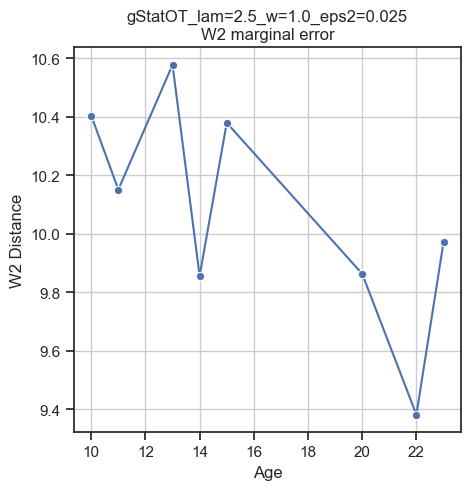

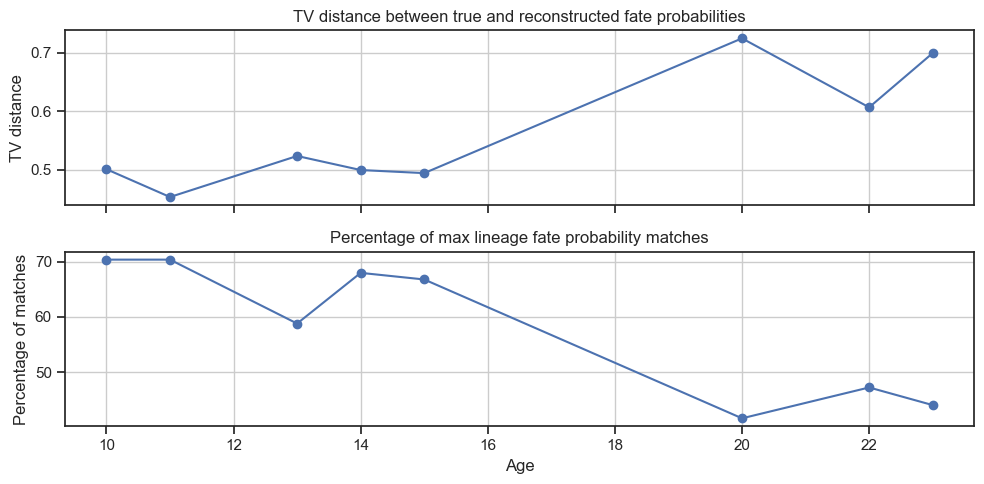

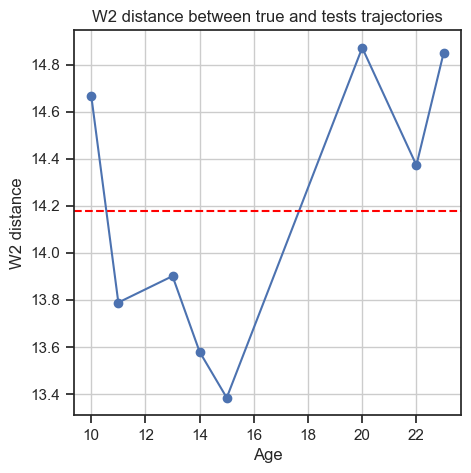

In [3]:
# 4 minutes to run (3 min solve) on NVIDIA RTX 4070 (n=250, N = 8*n = 2000 total cells)
n_steps = 65  
n_traj = 6000 
dt = 0.25

prenatal_down_sampled_adata, _ = utils.downsample_adata_by_age(prenatal_adata, n=n, time_key=adata_keys['time_key'], PRNG_KEY=key, chosen_times=None)


gSOT_prenatal = gStatOT(adata=prenatal_down_sampled_adata, adata_keys=adata_keys, dt=dt, 
                       cost_scaling='mean', dtype=jnp.float64)

model_params_prenatal = {
    'lam': 2.5,
    'w' : 1.0,
    'epsilon2': 0.025, 
    'epsilon1': 0.005,
    'epsilon3': 0.005,
    'r': 0.1 # scale on entropic OT objective
}

gSOT_prenatal.fit(model_params=model_params_prenatal, max_iter=50_000, constraint_tol=1e-4, verbose=True, 
         solver_kwargs={'inner_iter':5_000})
                                                                
gSOT_prenatal.get_lin_fate_probs(label_key='sink_type', all_labels=np.unique(prenatal_adata.obs['sink_type']))
gSOT_prenatal.get_trajectories(num_step=n_steps, num_traj=n_traj)
method_str_prenatal = 'gStatOT_' + 'lam=' + str(model_params_prenatal['lam']) + '_' + 'w=' + str(model_params_prenatal['w']) + '_' + 'eps2=' + str(model_params_prenatal['epsilon2'])



metric_tests_prenatal = metrics.Metric_Evaluator(method=method_str_prenatal,
                                        test_adata=prenatal_down_sampled_adata,
                                        true_adata=prenatal_adata,
                                        time_key=adata_keys['time_key'],
                                        embed_key=adata_keys['embed_key'],
                                        exp_dir=None)

metric_tests_prenatal.w2_marginal_error()
metric_tests_prenatal.fp_tv_error(label_key=adata_keys['cell_type_key'])
metric_tests_prenatal.w2_trajectory_error(test_dt=dt, true_dt=dt)

Cost scaled by mean
Completed 5000 total iterations, current error: 6.3122e-03
Completed 10000 total iterations, current error: 2.1844e-03
Completed 15000 total iterations, current error: 1.8890e-04
Completed 20000 total iterations, current error: 6.6632e-04
Completed 25000 total iterations, current error: 1.1070e-04
Completed 30000 total iterations, current error: 1.4089e-04
Completed 35000 total iterations, current error: 1.2914e-04
Completed 40000 total iterations, current error: 9.2462e-05
Ran 40000 iterations in 41.22 minutes.
Final objective value: -2.8008e-01
grad norm: 1.384e-04
max constraint error: 9.246e-05
ended in failed line search: False


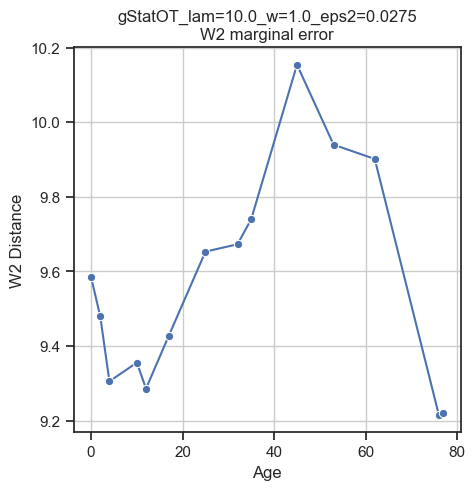

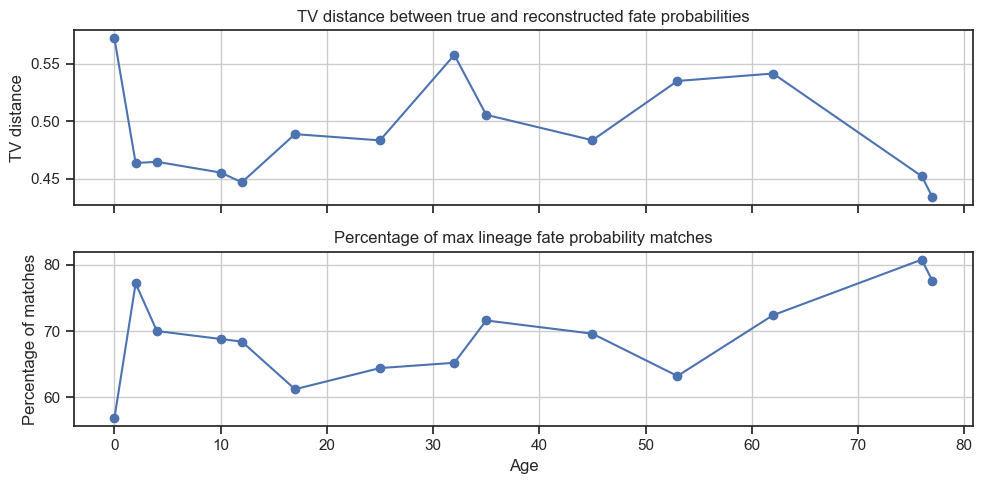

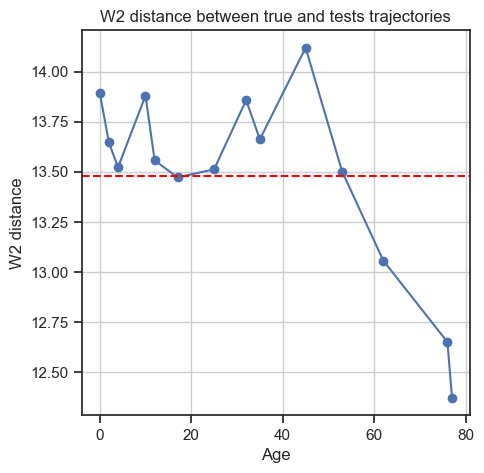

In [4]:
# 45 minutes to run (40 min solve) on NVIDIA RTX 4070 (n=250, N = 14*n = 3500 total cells)
n_steps = 80 
n_traj = 8500 
dt = 0.25
chosen_times = None 

postnatal_down_sampled_adata, _ = utils.downsample_adata_by_age(postnatal_adata, n=n, time_key=adata_keys['time_key'], PRNG_KEY=key, chosen_times=chosen_times)
gSOT_postnatal = gStatOT(adata=postnatal_down_sampled_adata, adata_keys=adata_keys, dt=dt, 
                       cost_scaling='mean', dtype=jnp.float64)

model_params_postnatal = {
    'lam': 10.0,
    'w' : 1.0,
    'epsilon2': 0.0275, 
    'epsilon1': 0.005,
    'epsilon3': 0.005, 
    'r': 0.1 # scale on entropic OT objective
    }

gSOT_postnatal.fit(model_params=model_params_postnatal, max_iter=50_000, constraint_tol=1e-4, verbose=True, 
         solver_kwargs={'inner_iter':5_000}) 

gSOT_postnatal.get_lin_fate_probs(label_key='sink_type', all_labels=np.unique(postnatal_adata.obs['sink_type']))
gSOT_postnatal.get_trajectories(num_step=n_steps, num_traj=n_traj)
method_str_postnatal = 'gStatOT_' + 'lam=' + str(model_params_postnatal['lam']) + '_' + 'w=' + str(model_params_postnatal['w']) + '_' + 'eps2=' + str(model_params_postnatal['epsilon2'])   
metric_tests_postnatal = metrics.Metric_Evaluator(method=method_str_postnatal,
                                        test_adata=postnatal_down_sampled_adata,
                                        true_adata=postnatal_adata,
                                        time_key=adata_keys['time_key'],
                                        embed_key=adata_keys['embed_key'],
                                        exp_dir=None)
metric_tests_postnatal.w2_marginal_error()
metric_tests_postnatal.fp_tv_error(label_key=adata_keys['cell_type_key'])
metric_tests_postnatal.w2_trajectory_error(test_dt=dt, true_dt=dt)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:03<00:00,  3.90it/s]


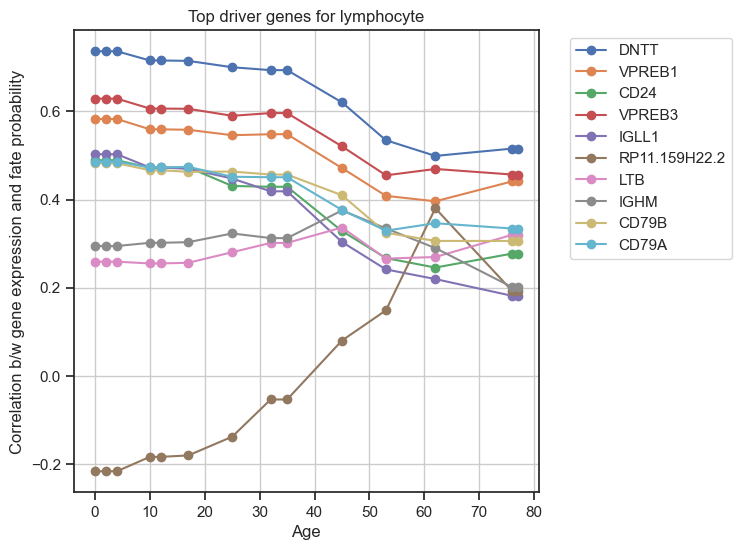

In [5]:
dg_identifier = driver_genes.gene_selection(adata=postnatal_down_sampled_adata,
                                 adata_keys=adata_keys)

fate_names = np.unique(postnatal_down_sampled_adata.obs[adata_keys['cell_type_key']])
dg_identifier.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
dg_identifier.plot_top_corr_over_age(fate_names=['lymphocyte'], n_top_genes=5, rank_by_abs_corr=False)

# StatOT

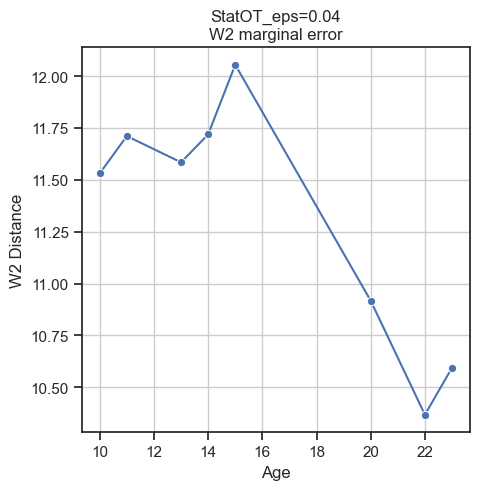

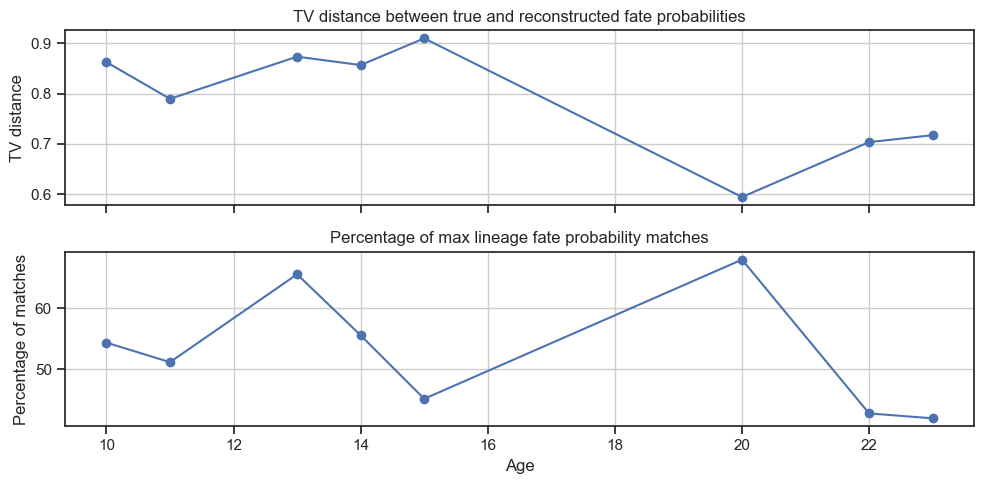

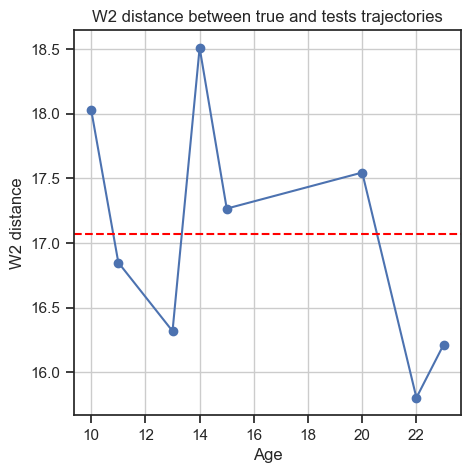

In [8]:
n_steps = 65 
n_traj = 6000 
dt = 0.25

prenatal_down_sampled_sot, _ = utils.downsample_adata_by_age(prenatal_adata, n=n, time_key=adata_keys['time_key'], PRNG_KEY=key, chosen_times=None)

sOT = StatOT(adata=prenatal_down_sampled_sot, adata_keys=adata_keys, dt=dt, dtype=jnp.float32)

sOT_params = {'epsilon': 0.04,
              'lse': True, # use log-sum-exp stabilization
              'cost_scaling': 'mean'}

sOT.fit(model_params=sOT_params, max_iter=15_000, verbose=False, constraint_tol=1e-4,)

sOT.get_lin_fate_probs(label_key='sink_type', all_labels=np.unique(prenatal_adata.obs['sink_type']))
sOT.get_trajectories(num_step=n_steps, num_traj=n_traj)
method_str = 'StatOT_' + 'eps=' + str(sOT_params['epsilon']) 

statot_metric_tests = metrics.Metric_Evaluator(method=method_str,
                                        test_adata=prenatal_down_sampled_sot,
                                        true_adata=prenatal_adata,
                                        time_key=adata_keys['time_key'],
                                        embed_key=adata_keys['embed_key'],
                                        exp_dir=None,
                                        full_supp=False)

statot_metric_tests.w2_marginal_error()
statot_metric_tests.fp_tv_error(label_key=adata_keys['cell_type_key'])
statot_metric_tests.w2_trajectory_error(test_dt=dt, true_dt=dt)

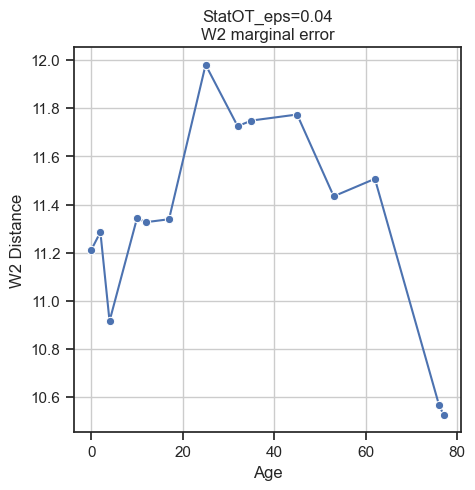

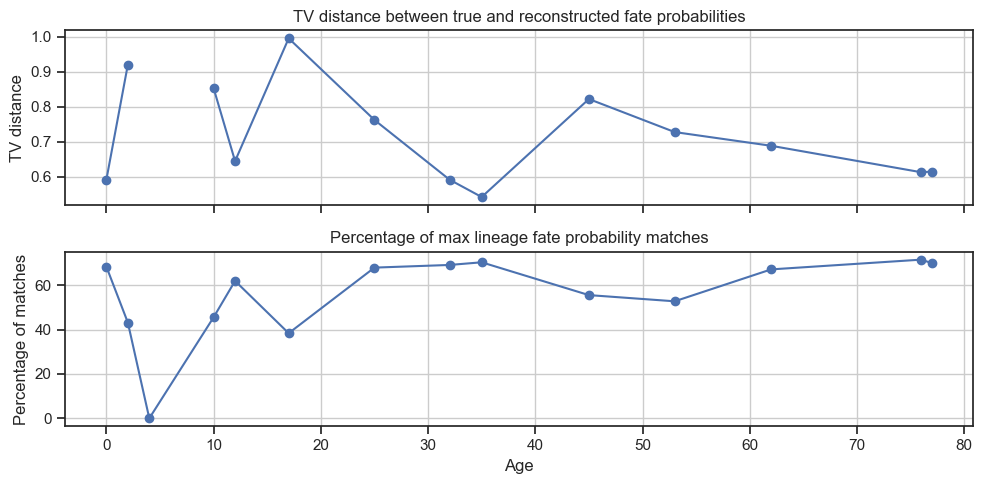

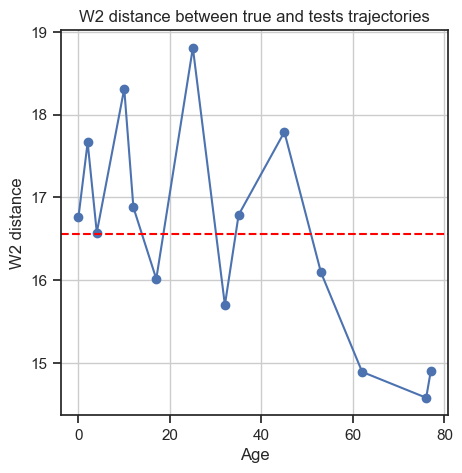

In [9]:
# postnatal

n_traj = 8500
n_steps = 80 
dt = 0.25
postnatal_down_sampled_sot, _ = utils.downsample_adata_by_age(postnatal_adata, n=n, time_key=adata_keys['time_key'], PRNG_KEY=key, chosen_times=None)

sOT = StatOT(adata=postnatal_down_sampled_sot, adata_keys=adata_keys, dt=dt, dtype=jnp.float32)

sOT_params = {'epsilon': 0.04,
              'lse': True,
              'cost_scaling': 'mean'}

sOT.fit(model_params=sOT_params, max_iter=15_000, verbose=False, constraint_tol=1e-4,)

sOT.get_lin_fate_probs(label_key='sink_type', all_labels=np.unique(postnatal_adata.obs['sink_type']))
sOT.get_trajectories(num_step=n_steps, num_traj=n_traj)
method_str = 'StatOT_' + 'eps=' + str(sOT_params['epsilon']) 

statot_metric_tests = metrics.Metric_Evaluator(method=method_str,
                                        test_adata=postnatal_down_sampled_sot,
                                        true_adata=postnatal_adata,
                                        time_key=adata_keys['time_key'],
                                        embed_key=adata_keys['embed_key'],
                                        exp_dir=None,
                                        full_supp=False)

statot_metric_tests.w2_marginal_error()
statot_metric_tests.fp_tv_error(label_key=adata_keys['cell_type_key'])
statot_metric_tests.w2_trajectory_error(test_dt=dt, true_dt=dt)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


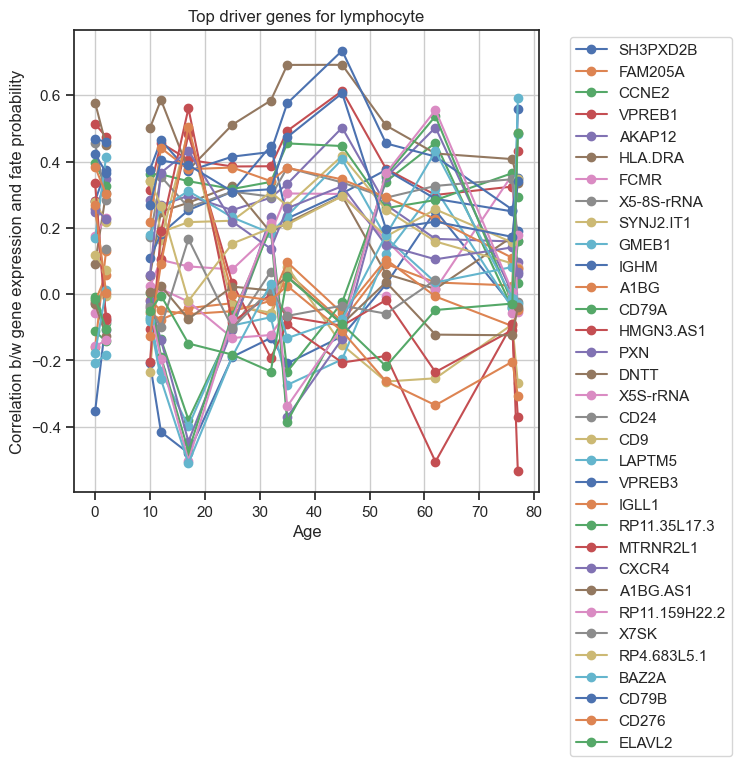

In [10]:
dg_identifier = driver_genes.gene_selection(adata=postnatal_down_sampled_sot,
                                 adata_keys=adata_keys, full_supp=False)

fate_names = np.unique(postnatal_down_sampled_sot.obs[adata_keys['cell_type_key']])
dg_identifier.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
dg_identifier.plot_top_corr_over_age(fate_names=['lymphocyte'], n_top_genes=5, rank_by_abs_corr=False)